# Drone Model-Predictive Control

## Package Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import signal

from pydrake.all import (
    AddMultibodyPlantSceneGraph, DiagramBuilder,DirectCollocation, FindResourceOrThrow, LinearSystem,
    LogVectorOutput, MathematicalProgram, MeshcatVisualizerCpp, Parser, plot_system_graphviz, PiecewisePolynomial,   
    RandomSource, RandomDistribution, SceneGraph, Simulator, Solve, StartMeshcat, TrajectorySource, VectorSystem )

from pydrake.examples.quadrotor import (QuadrotorGeometry, QuadrotorPlant, StabilizingLQRController)

from underactuated.meshcat_cpp_utils import MeshcatSliders



In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://7a2da9b8-cd38-4703-b181-4b0e0b197067.deepnoteproject.com/7000/


## Wind Turbulence Model 

A standard mathematical model used to approximate continuous wind gusts is the Dryden Wind Turbulence Model.

sigma_u = 2.5737730694567573, L_u = 505.1693349051267, vehicle_speed = 5
H_ug_gain = 20.64162108931089
Lu/V = 101.03386698102534
TransferFunctionContinuous(
array([0.20430398]),
array([1.        , 0.00989767]),
dt: None
)


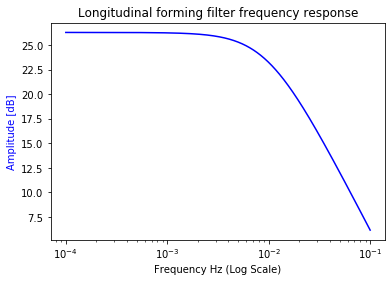

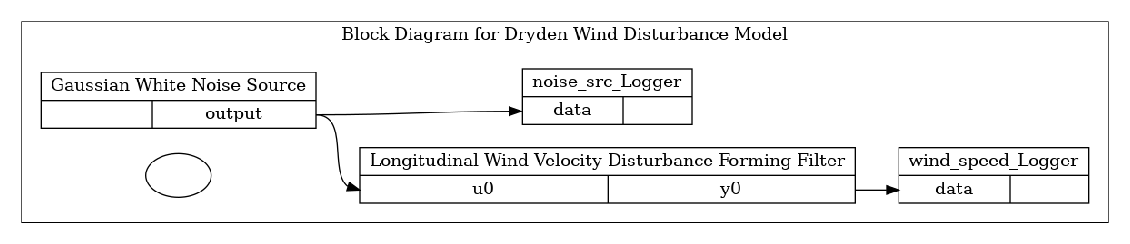

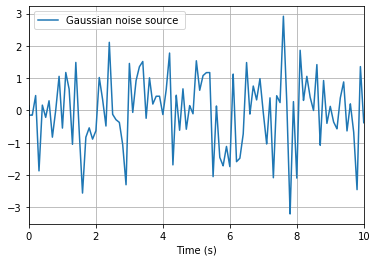

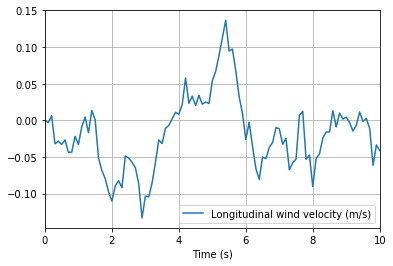

127


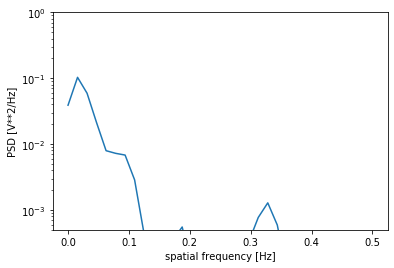

In [3]:
# the dryden noise class 

class DrydenWindDisturbance:

    ################ STEP 1 - generate approximately gaussian white noise using the drake RandomSource class ####################

    #################################################################################################
    # STEP 2 - pass through a linear system to produce colored noise that matches the Dryden model 
    #################################################################################################

    ########################################### Dryden wind turbulence model ####################################################
    # Power Spectral Densities of the linear components of the wind velocities along the 3 axis. 
    #
    # linear wind velocities = (u_g, v_g, w_g)
    #
    # Linear PSDs:
    #
    # I_u (omega) = (sigma_u ** 2) * (2 L_u / pi ) * (1 / (1 + L_u * omega) ** 2) )
    #
    # I_v (omega) = (sigma_v ** 2) * (2 L_v / pi ) * (    (1 + 12 * (L_v * omega) ** 2 )  /  ( (1 + 4 * (L_v * omega) ** 2 ) ) ** 2 )     )
    #
    # I_w (omega) = (sigma_w ** 2) * (2 L_w / pi ) * (    (1 + 4 * (L_w * omega) ** 2 )  /  ( (1 + 12 * (L_w * omega) ** 2 ) ) ** 2 )     )
    #
    #
    #

    def __init__(self, sampling_interval):

        # define the number of outputs for the gaussian noise source used to generate 
        # Dryden wind disturbance
        self.num_outputs = 1
        self.sampling_interval = sampling_interval

    def calculate_model_parameters(self, altitude, wind_speed):
        #########################
        # turbulence intensities( sigma_u, sigma_v, sigma_w), and turbulence lengths (L_u, L_v, L_w) are 
        # functions of altitude h, divided into three regions:
        #
        # wind_speed = 15 knots for light turbulence, 30 knots for moderate turbulence, 
        # 45 knots for severe turbulence
        #
        ######################## Region 1: h < 1000
        # 
        # L_w = h
        # L_u = L_v = h / (0.177 + 0.000823h) ** 1.2
        # 
        # sigma_w = 0.1 * wind_speed
        # sigma_u / sigma_w = sigma_v / sigma_w = 1 / (0.177 + 0.000823h) ** 0.4
        # 
        #
        ######################### Region 2: 1000 < h < 2000
        #
        # Calculated be performing linear interpolation between regions 1 & 3
        # 
        #
        ######################### Region 3: h > 2000
        #
        # L_u = L_v = L_w = 1750
        #
        # sigmas are determined by a lookup table 
        #

        # units of altitude in ft
        if (altitude < 1000):

            sigma_w = 0.1 * wind_speed
            
            sigma_v  = sigma_w / ( (0.177 + 0.000823* altitude) ** 0.4 )

            sigma_u = sigma_v

            L_w = altitude

            L_v = altitude / ( (0.177 + 0.000823* altitude) ** 1.2 )

            L_u = L_v

        elif (1000 <= altitude <= 2000):
            print("altitude in region 2: 1000 - 2000 ft")
        # altitude > 2000ft
        else:
            print("altitude in region 3: > 2000 ft")

        return sigma_u, sigma_v, sigma_w, L_u, L_v, L_w

    
    def ug_filter(self, sigma_u, L_u, vehicle_speed):

        # H_ug(s) = sigma_u * np.sqrt( 2 * L_u / (np.pi * vehicle_speed)) * (1 / (1 + L_u/V s))

        print(f"sigma_u = {sigma_u}, L_u = {L_u}, vehicle_speed = {vehicle_speed}")

        # define gain for transfer function that will produce PSD of the linear wind velocity in direction u)
        H_ug_gain = sigma_u * np.sqrt( 2 * L_u / (np.pi * vehicle_speed))
        print(f"H_ug_gain = {H_ug_gain}")
        print(f"Lu/V = {L_u / vehicle_speed}")
        
        #define lowpass filter that will produce longitudinal linear wind disturbance
        H_ug_tf = signal.TransferFunction(H_ug_gain, [ L_u / vehicle_speed, 1] )

        print(H_ug_tf)

        w, H = signal.freqresp(H_ug_tf, w=None, n=10000)

        plt.figure(0)
        plt.title('Longitudinal forming filter frequency response')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        #plt.xlabel('Frequency [rad/sec]')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_ug_ss = H_ug_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_ug_sys = LinearSystem(H_ug_ss.A, H_ug_ss.B, H_ug_ss.C, H_ug_ss.D )

        return self.H_ug_sys

    

    def connect_Dryden_noise_src(self, builder):

        # define gaussiang random noise input
        gaussian_distribution = RandomDistribution(1) # parameter of 1 = gaussian distribution
        self.white_noise_src = RandomSource(gaussian_distribution, self.num_outputs, self.sampling_interval)


        builder.AddSystem(self.white_noise_src)
        builder.AddSystem(self.H_ug_sys)
        builder.Connect(self.white_noise_src.get_output_port(0), self.H_ug_sys.get_input_port(0))


        self.white_noise_src.set_name("Gaussian White Noise Source")
        self.H_ug_sys.set_name("Longitudinal Wind Velocity Disturbance Forming Filter")

        return self.white_noise_src





sampling_interval = 0.1
altitude = 100
wind_speed = 15
vehicle_speed = 5

dryden_noise = DrydenWindDisturbance(sampling_interval)

sigma_u, sigma_v, sigma_w, L_u, L_v, L_w = dryden_noise.calculate_model_parameters(altitude, wind_speed)

H_ug_sys = dryden_noise.ug_filter(sigma_u, L_u, vehicle_speed)

builder = DiagramBuilder()

white_noise_src = dryden_noise.connect_Dryden_noise_src(builder)

# logger that records the state trajectory during simulation
logger = LogVectorOutput(H_ug_sys.get_output_port(), builder)
logger.set_name('wind_speed_Logger')

# logger that records the state trajectory during simulation
logger2 = LogVectorOutput(white_noise_src.get_output_port(), builder)
logger2.set_name('noise_src_Logger')

diagram = builder.Build()

############### Visualize 
# give names to the blocks (just to make the plot nicer)
diagram.set_name('Block Diagram for Dryden Wind Disturbance Model')
# plot current diagram
plt.figure(1, figsize=(20, 10))
plot_system_graphviz(diagram)


#Hug_Output = H_ug_sys.AllocateOutput()
#print(Hug_Output.num_ports())


# simulation time
sim_time = 10

# set up a simulator
simulator = Simulator(diagram)


context = simulator.get_mutable_context()
context.SetTime(0.) # reset current time

# simulate from zero to sim_time
simulator.Initialize()
simulator.AdvanceTo(sim_time)

plt.figure(2)
# longitudinal wind velocity as a function of time
log2 = logger2.FindLog(context)
plt.plot(
    log2.sample_times(),
    log2.data()[0,:],
    label='Gaussian noise source '
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(3)
# longitudinal wind velocity as a function of time
log = logger.FindLog(context)
plt.plot(
    log.sample_times(),
    log.data()[0,:],
    label='Longitudinal wind velocity (m/s)'
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()


print(len((log.data()[0,:])) )
plt.figure(4)
#fs = vehicle_speed
fs = 1.0
f, PSD_ug = signal.welch(log.data()[0,:], fs, nperseg=64)
plt.semilogy(f, PSD_ug)
plt.ylim([0.5e-3, 1])
plt.xlabel('spatial frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()











## Non-Linear Trajectory Optimization for the Quadrotor

Find an optimal trajectory from an initial condition to a target destination, that minimizes time to target destination, and adheres to thrust limits

In [4]:
def optimize_quadrotor_trajectory(quadrotor_plant, quadrotor_context, init_state, final_state, thrust_limit, num_time_samples):

    # use direct collocation to integrate quadrotor dynamics
    # DirectCollation classe performs Direct transcription trajectory optimization using nonlinear programming and collocation
    # It assumes a first-order hold on the input trajectory and a cubic spline representation of the state trajectory, and adds dynamic constraints 
    # (and running costs) to the midpoints as well as the breakpoints in order to achieve a 3rd order integration accuracy.
    dircol = DirectCollocation(quadrotor_plant,
                            quadrotor_context,
                            num_time_samples=num_time_samples,
                            minimum_timestep=0.05,
                            maximum_timestep=0.2)

    #Returns a reference to the MathematicalProgram associated with the trajectory optimization problem.
    prog = dircol.prog()

    # add constraint that enforces that all timesteps have equal duration (ensures more efficient optimization)
    dircol.AddEqualTimeIntervalsConstraints()

    # Returns placeholder decision variables (not actually declared as decision variables in the MathematicalProgram) 
    # associated with the input, u, but with the time-index undetermined.
    u = dircol.input()

    print(f"input = {u}")

    # enforce individual thrust limits for each propellor
    dircol.AddConstraintToAllKnotPoints(u[0] <= thrust_limit)
    dircol.AddConstraintToAllKnotPoints(-thrust_limit <= u[0])

    dircol.AddConstraintToAllKnotPoints(u[1] <= thrust_limit)
    dircol.AddConstraintToAllKnotPoints(-thrust_limit <= u[1])

    dircol.AddConstraintToAllKnotPoints(u[2] <= thrust_limit)
    dircol.AddConstraintToAllKnotPoints(-thrust_limit <= u[2])

    dircol.AddConstraintToAllKnotPoints(u[3] <= thrust_limit)
    dircol.AddConstraintToAllKnotPoints(-thrust_limit <= u[3])

    # add initial state constraint (first parameter is upper bound, second parameter is lower bound, 3rd parameter is variable being constrained)
    prog.AddBoundingBoxConstraint(init_state, init_state,
                                  dircol.initial_state())

    # add final state constraint
    prog.AddBoundingBoxConstraint(final_state, final_state,
                                  dircol.final_state())


    R = 100  # Cost on input "effort".
    dircol.AddRunningCost(R * u[0]**2)
    dircol.AddRunningCost(R * u[1]**2)
    dircol.AddRunningCost(R * u[2]**2)
    dircol.AddRunningCost(R * u[3]**2)

    # Add a final cost equal to the total duration.
    dircol.AddFinalCost(dircol.time())

    # Construct an initial guess at an optimal trajectory
    # PiecewisePolynomial.FirstOrderHold Constructs a piecewise linear PiecewisePolynomial using matrix samples.
    breaks = [0., 4.]
    samples = np.column_stack((initial_state, final_state))
    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(breaks, samples)  # yapf: disable

    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    result = Solve(prog)
    assert (result.is_success())

    u_trajectory = dircol.ReconstructInputTrajectory(result)
    x_trajectory = dircol.ReconstructStateTrajectory(result)

    return u_trajectory, x_trajectory


#calculate optimal trajectory and simulation

initial_state = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

final_state = [-1, -3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# limit is the 2-norm of the thrust vector 
thrust_limit = 20.0
#we want to have an odd number
num_time_samples = 21

quadrotor_plant = QuadrotorPlant()
quadrotor_context = quadrotor_plant.CreateDefaultContext()

u_trajectory, x_trajectory = optimize_quadrotor_trajectory(quadrotor_plant, quadrotor_context, initial_state, final_state, thrust_limit, num_time_samples)

builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_trajectory))

# Set up visualization in MeshCat
scene_graph = builder.AddSystem(SceneGraph())
QuadrotorGeometry.AddToBuilder(builder, source.get_output_port(0), scene_graph)
meshcat.Delete()
meshcat.ResetRenderMode()
meshcat.SetProperty('/Background','visible',False)
MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
# end setup for visualization

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
sim_context = simulator.get_mutable_context()

#sim_context.SetContinuousState(initial_state)

simulator.set_target_realtime_rate(1.0)
meshcat.AddButton('Stop Simulation')
while meshcat.GetButtonClicks('Stop Simulation') < 1:
    
    simulator.AdvanceTo(simulator.get_context().get_time() + 1.0)

meshcat.DeleteAddedControls()



    


input = [Variable('u(0)', Continuous) Variable('u(1)', Continuous)
 Variable('u(2)', Continuous) Variable('u(3)', Continuous)]


KeyboardInterrupt: 

## Wire Up Block Diagram &amp; Run simulation

simulation complete


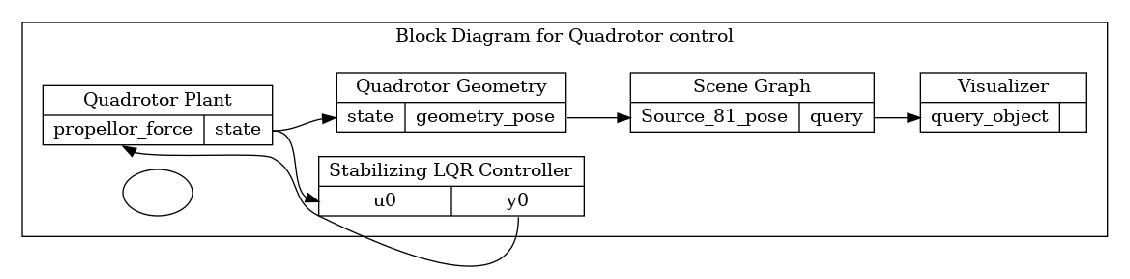

In [ ]:
def simulate_quadrotor():

    #define diagram builder, used to connect plant and controller inputs / outputs
    builder = DiagramBuilder()


    quadrotor_plant = QuadrotorPlant()

    plant = builder.AddSystem(quadrotor_plant)

    controller = builder.AddSystem(StabilizingLQRController(plant, [1, 2, 2]))
    builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Set up visualization in MeshCat
    scene_graph = builder.AddSystem(SceneGraph())
    quad_geometry = QuadrotorGeometry.AddToBuilder(builder, plant.get_output_port(0), scene_graph)
    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty('/Background','visible',False)
    vizualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    # end setup for visualization



    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()



    #continuous_state = context.get_mutable_continuous_state_vector()

    # Set the initial conditions (theta1, theta2, theta1dot, theta2dot)
    #context.SetContinuousState([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    context.SetContinuousState(0.5*np.random.randn(12,))

   # print(f"continuous state {continuous_state}")
    #print(f"size of continuous state {continuous_state.size()}")
    simulator.set_target_realtime_rate(1.0)
    meshcat.AddButton('Stop Simulation')
    while meshcat.GetButtonClicks('Stop Simulation') < 1:
        
        simulator.AdvanceTo(simulator.get_context().get_time() + 1.0)

    meshcat.DeleteAddedControls()

    print("simulation complete")

    ############### Visualize 
    # give names to the blocks (just to make the plot nicer)
    diagram.set_name('Block Diagram for Quadrotor control')
    plant.set_name('Quadrotor Plant')
    quad_geometry.set_name("Quadrotor Geometry")
    controller.set_name('Stabilizing LQR Controller')
    scene_graph.set_name('Scene Graph')
    vizualizer.set_name('Visualizer')

    # plot current diagram
    plt.figure(figsize=(20, 10))
    plot_system_graphviz(diagram)



simulate_quadrotor()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7a2da9b8-cd38-4703-b181-4b0e0b197067' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>